In [285]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import matplotlib.ticker
from datetime import datetime

sns.set(font_scale=0.9, style='whitegrid', font="CMU Sans Serif")

pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,1.5)
mpl.rcParams['figure.dpi'] = 100

In [286]:
OUTER_REPEATS = 5
INTERVAL = 10
MIN_MPL = 1
MAX_MPL = 32
PREFIX = "cuda"
FUNC = "matmul"
N=10000
NUM_GPU = 8
MAX_REQ_PER_GPU = 4

GPU_BUS_IDS = {
    "00000000:15:00.0": 1,
    "00000000:16:00.0": 2,
    "00000000:3A:00.0": 3,
    "00000000:3B:00.0": 4,
    "00000000:89:00.0": 5,
    "00000000:8A:00.0": 6,
    "00000000:B2:00.0": 7,
    "00000000:B3:00.0": 8,
}

BASE_FOLDER = "./results"

In [287]:
# go through all the gpu monitoring and remove that weird whitespace that nvidia-smi inserts
for filename in glob.glob(f"{BASE_FOLDER}/*gpu-monitoring.csv"):
    # read the file, line by line
    with open(filename, "r") as f:
        lines = f.readlines()
    # remove the whitespace
    # lines = [line.strip() for line in lines]
    lines = [line.replace(", ", ",") for line in lines]
    lines = [line.strip() for line in lines]
    # filter empty lines
    lines = [line for line in lines if line]
    # write the file back
    with open(filename, "w") as f:
        f.write("\n".join(lines))


In [342]:
# write all measurements into a big dataframe
tmp = []

for i in range(1, OUTER_REPEATS+1):
    df = pd.read_csv(f"{BASE_FOLDER}/autoscaling-{PREFIX}-{FUNC}-{N}-{i}.csv")

    df["repeat"] = i
    df["inner_time"] = df["inner_time_ms"] / 1000
    df["outer_time"] = df["outer_time_ms"] / 1000
    df["rel_time"] = df["timestamp"] - df["timestamp"].min()

    # the longest NUM_GPU outer_times are cold starts
    # df["cold_start"] = df["outer_time"].rank(ascending=False) <= NUM_GPU
    df["start_type"] = df["cold_start"].apply(lambda x: "cold" if x==1 else "warm")

    df["outer_end"] = df["rel_time"] + df["outer_time"]

    df.sort_values(by="timestamp", inplace=True)

    server_df = pd.read_csv(f"{BASE_FOLDER}/autoscaling-{FUNC}-{N}-{i}-serverlogs.csv")
    # weird trickery!!!
    # copy a row
    server_df.loc[-1] = {"timestamp": 0, "gpu": -1, "num_workers": MAX_REQ_PER_GPU}
    server_df.sort_values(by="timestamp", inplace=True)

    # do a left join to add num_workers to the df
    # but use closest timestamp, not exact timestamp, using merge_asof
    df = pd.merge_asof(df, server_df, on="timestamp", direction="backward")

    df["num_workers"] = df["gpu"] + 1

    # for cold starts, shift gpu by 1
    df.loc[df["cold_start"]==1, "num_workers"] = df["num_workers"] + 1

    # drop the gpu column
    df.drop(columns=["gpu"], inplace=True)

    # cut off everything when the inner_time starts to be 0 for the first time
    # find the first time when inner_time is 0
    first_zero = df[df["inner_time"] == 0.0]["timestamp"].min()
    print(first_zero)
    # check that its actually 0
    if not np.isnan(first_zero):
        df = df[df["timestamp"] < first_zero]

    tmp.append(df)

df = pd.concat(tmp)
df.dropna(inplace=True)
df.head()

nan
1695221182.598003
nan
1695222239.8106391
nan


,timestamp,inner_time_ms,outer_time_ms,setup_time,cold_start,copy,concurrency,repeat,inner_time,outer_time,rel_time,start_type,outer_end,num_workers
0,1.695220e+09,1587.727,3980.86946,654.751,True,0,1,1,1.587727,3.980869,0.000000,cold,3.980869,1
1,1.695220e+09,1571.862,2338.82316,651.683,False,0,1,1,1.571862,2.338823,3.981154,warm,6.319977,1
2,1.695220e+09,1574.503,2348.79119,654.702,False,0,1,1,1.574503,2.348791,6.320161,warm,8.668952,1
3,1.695220e+09,1576.367,2347.55198,654.322,False,0,2,1,1.576367,2.347552,8.669040,warm,11.016592,1
4,1.695220e+09,1587.653,2376.69883,670.889,False,1,2,1,1.587653,2.376699,9.938183,warm,12.314881,1


In [334]:
gpu_dfs = []
for i in range(1, OUTER_REPEATS+1):
    # read the gpu activity logs
    gpu_df = pd.read_csv(f"{BASE_FOLDER}/autoscaling-{FUNC}-{N}-{i}-gpu-monitoring.csv", names=["timestamp", "bus", "utilization"], header=None)
    gpu_df["gpu"] = gpu_df["bus"].apply(lambda x: GPU_BUS_IDS[x])
    gpu_df.drop(columns=["bus"], inplace=True)
    gpu_df.sort_values(by="timestamp", inplace=True)
    # convert timestamp to epoch seconds
    gpu_df["timestamp"] = gpu_df["timestamp"].apply(lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S.%f").timestamp())

    # please do not kill me for this
    # experiments were run in a different timezone
    # it's exactly 7 hours behind
    gpu_df["timestamp"] = gpu_df["timestamp"] + 7*60*60

    gpu_df["repeat"] = i

    # pivot the gpu_df
    # we need columns gpu_1, gpu_2, ..., gpu_8
    # and values utilization, but we have a timestamp for each value
    # so we need to do a pivot
    # gpu_df = gpu_df.pivot(index="timestamp", columns="gpu", values="utilization")
    # remove the gpu index
    # drop gpu index name
    gpu_df.columns.name = None

    # print(gpu_df.head())

    # relative time depends on the experiment
    gpu_df["rel_time"] = gpu_df["timestamp"] - df[df["repeat"] == i]["timestamp"].min()
    # remove with negative rel_time
    gpu_df = gpu_df[gpu_df["rel_time"] >= 0]

    # stop at the last record
    gpu_df = gpu_df[gpu_df["rel_time"] <= df[df["repeat"] == i]["rel_time"].max()]

    gpu_dfs.append(gpu_df)

gpu_df = pd.concat(gpu_dfs)
gpu_df.reset_index(inplace=True, drop=True)
# gpu_df.dropna(inplace=True)
gpu_df.head()


,timestamp,utilization,gpu,repeat,rel_time
0,1.695221e+09,0,6,2,0.080506
1,1.695221e+09,0,5,2,0.080506
2,1.695221e+09,0,4,2,0.080506
3,1.695221e+09,0,1,2,0.080506
4,1.695221e+09,0,2,2,0.080506


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='repeat', ylabel='concurrency'>

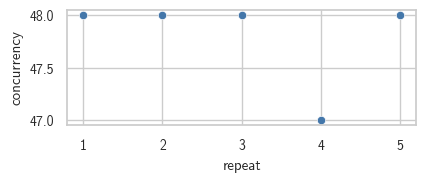

In [343]:
# across our repeats, how many MPL could we achieve
# plot max concurrency for each repeat
# we need to group by repeat and num_workers
# and then take the max of the inner_time
# and then take the max of that
# and then plot that
mpl_df = df.groupby(["repeat"])["concurrency"].max().reset_index()
sns.scatterplot(data=mpl_df, x="repeat", y="concurrency", color=pal[0])

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

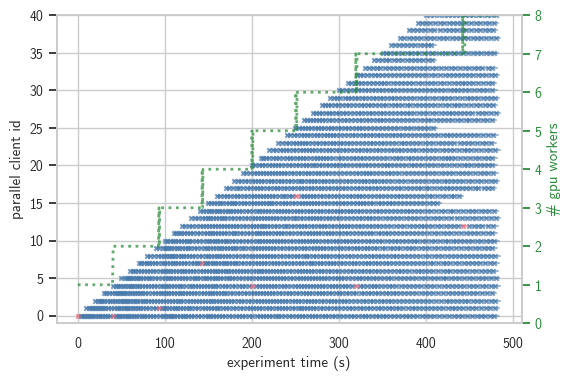

In [345]:
# let's make a simple scatterplot first?
# fig, ax = plt.subplots()
# sns.scatterplot(data=df, x="rel_time", y="copy", size="inner_time", alpha=0.5, legend=False, ax=ax, hue="cold_start")
# make a plot where each observation is a line from timestamp to timestamp+outer_time, with rel_time on x and copy on y axis
# we need to do some preprocessing first
# we need to add a column for the end of the outer_time
REPEAT_TO_PLOT = 5

df_graph = df[df["repeat"] == REPEAT_TO_PLOT]

# now plot
fig, ax = plt.subplots(figsize=(6,4))
for i, row in df_graph.iterrows():
    # plot the line
    ax.plot([row["rel_time"], row["outer_end"]], [row["copy"], row["copy"]], color=("#EE6677" if row["cold_start"] else "#4477AA"), alpha=0.5)
    # plot the starting point
    ax.scatter([row["rel_time"]], [row["copy"]], color=("#EE6677" if row["cold_start"] else "#4477AA"), alpha=0.7, marker="x", s=10)

ax.set(ylim=(-1, 40))
ax.set(ylabel="parallel client id")
ax.set(xlabel="experiment time (s)")

ax2 = ax.twinx()
sns.lineplot(data=df_graph, x="rel_time", y="num_workers", color="#228833", legend=False, ax=ax2, linestyle=":", alpha=0.7, linewidth=2)
ax2.grid(False)
ax2.set(ylim=(0, 8))
ax2.set(ylabel="# gpu workers")
ax2.yaxis.label.set_color('#228833')
ax2.tick_params(axis='y', colors='#228833')

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

[Text(0, 0.5, '# gpu workers')]

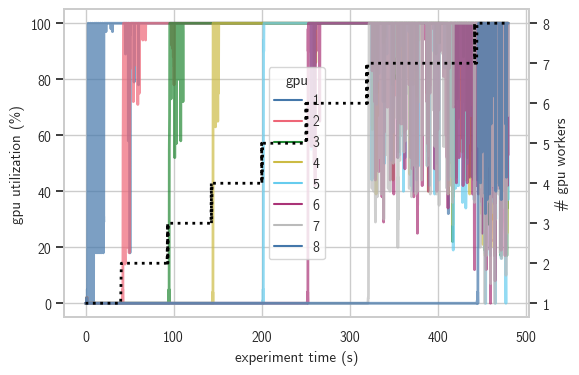

In [314]:
# now we plot the gpu utilization
# on the other axis, we want num workers

df_graph = df[df["repeat"] == REPEAT_TO_PLOT]
gpu_df_graph = gpu_df[gpu_df["repeat"] == REPEAT_TO_PLOT]

fig, ax = plt.subplots(figsize=(6,4))

sns.lineplot(data=gpu_df_graph, x="rel_time", y="utilization", hue="gpu", ax=ax, alpha=0.7, linewidth=2, palette=pal)
ax.set(ylabel="gpu utilization (%)")
ax.set(xlabel="experiment time (s)")

ax2 = ax.twinx()

sns.lineplot(data=df_graph, x="rel_time", y="num_workers", color="black", legend=False, ax=ax2, linestyle=":", linewidth=2)
ax2.grid(False)
ax2.set(ylabel="# gpu workers")

In [315]:
# make a combined gpu dataframe
combined_gpu = gpu_df_graph[gpu_df_graph["gpu"] == 1][["rel_time", "utilization"]]
combined_gpu["utilization_1"] = combined_gpu["utilization"]

for gpu in range(2, NUM_GPU+1):
    combined_gpu = pd.merge_asof(combined_gpu, gpu_df_graph[gpu_df_graph["gpu"] == gpu][["rel_time", "utilization"]], on="rel_time", direction="backward", suffixes=("", f"_{gpu}"))

combined_gpu["total_utilization"] = combined_gpu[[f"utilization_{gpu}" for gpu in range(1, NUM_GPU+1)]].sum(axis=1)
combined_gpu["avg_utilization"] = combined_gpu["total_utilization"] / NUM_GPU

combined_gpu

,rel_time,utilization,utilization_1,utilization_2,utilization_3,utilization_4,utilization_5,utilization_6,utilization_7,utilization_8,total_utilization,avg_utilization
0,0.077922,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000
1,0.179923,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2,0.280922,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,0.382922,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
4,0.483922,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
4694,479.809922,100,100,100,100.0,100.0,73.0,100.0,100.0,100.0,773.0,96.625
4695,479.911922,100,100,100,100.0,100.0,73.0,100.0,100.0,100.0,773.0,96.625
4696,480.013922,100,100,100,100.0,100.0,37.0,100.0,67.0,100.0,704.0,88.000
4697,480.116922,100,100,100,100.0,100.0,37.0,100.0,69.0,100.0,706.0,88.250


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_32717/612714755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpu_df_graph["rel_time_dt"] = pd.to_datetime(gpu_df_graph["rel_time"], unit="s")
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-pa

[Text(0, 0.5, '# gpu workers')]

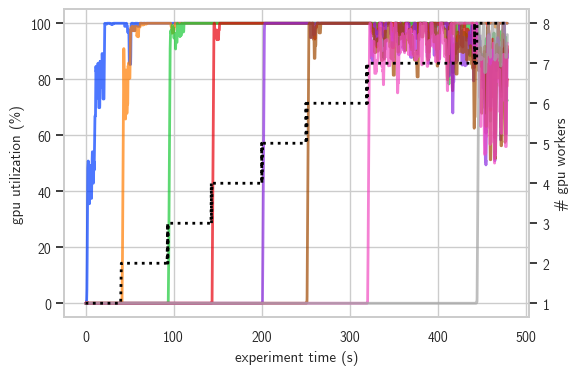

In [316]:
# rolling 1s mean of the gpu utilization
# make rel_time a time column
gpu_df_graph["rel_time_dt"] = pd.to_datetime(gpu_df_graph["rel_time"], unit="s")

# rolling_df = gpu_df.rolling("100ms", on="rel_time_dt").mean()

fig, ax = plt.subplots(figsize=(6,4))

continuous_pal = sns.color_palette("bright", n_colors=NUM_GPU)
for gpu in range(1, NUM_GPU+1):
    rolling_df = gpu_df_graph[gpu_df_graph["gpu"] == gpu].rolling("2s", on="rel_time_dt").mean()
    sns.lineplot(data=rolling_df, x="rel_time", y="utilization", ax=ax, alpha=0.7, linewidth=2, color=continuous_pal[gpu-1])

# sns.lineplot(data=gpu_df, x="rel_time", y="utilization", hue="gpu", ax=ax, alpha=0.7, linewidth=2, palette="viridis")
ax.set(ylabel="gpu utilization (%)")
ax.set(xlabel="experiment time (s)")

ax2 = ax.twinx()

sns.lineplot(data=df_graph, x="rel_time", y="num_workers", color="black", legend=False, ax=ax2, linestyle=":", linewidth=2)
ax2.grid(False)
ax2.set(ylabel="# gpu workers")

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_32717/2740998710.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=combined_rolling_gpu, x="rel_time", y="total_utilization", ax=ax, alpha=0.7, linewidth=2, palette="viridis")
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

[(0.0, 8.0)]

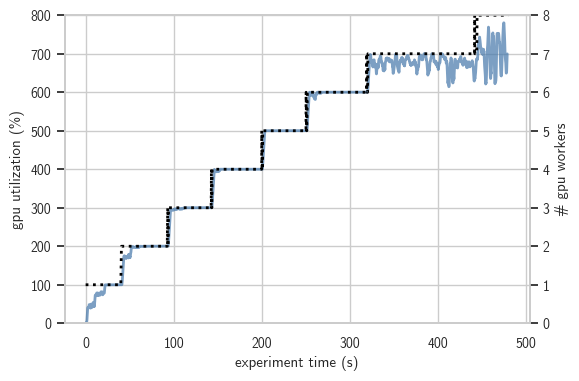

In [317]:
fig, ax = plt.subplots(figsize=(6,4))

combined_gpu["rel_time_dt"] = pd.to_datetime(combined_gpu["rel_time"], unit="s")
combined_rolling_gpu = combined_gpu.rolling("2500ms", on="rel_time_dt").mean()

sns.lineplot(data=combined_rolling_gpu, x="rel_time", y="total_utilization", ax=ax, alpha=0.7, linewidth=2, palette="viridis")
ax.set(ylabel="gpu utilization (%)")
ax.set(xlabel="experiment time (s)")
ax.set(ylim=(0, 800))

ax2 = ax.twinx()

sns.lineplot(data=df_graph, x="rel_time", y="num_workers", color="black", legend=False, ax=ax2, linestyle=":", linewidth=2)
ax2.grid(False)
ax2.set(ylabel="# gpu workers")
ax2.set(ylim=(0, 8))

In [318]:
# add the GPU utilization together by timestamp
# we need to do this because we have multiple GPUs
# and we want to plot the total utilization
# we need to do this for each repeat
# we need to do this for each timestamp
gpu_df_graph["total_utilization"] = 0
for i in range(1, OUTER_REPEATS+1):
    for timestamp in gpu_df_graph[gpu_df_graph["repeat"] == i]["rel_time"].unique():
        # get the rows for this timestamp
        rows = gpu_df_graph[(gpu_df_graph["repeat"] == i) & (gpu_df_graph["rel_time"] == timestamp)]
        # sum the utilization
        total_utilization = rows["utilization"].sum()
        # set the total_utilization for this timestamp
        gpu_df_graph.loc[(gpu_df_graph["repeat"] == i) & (gpu_df_graph["rel_time"] == timestamp), "total_utilization"] = total_utilization

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_32717/2933085948.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpu_df_graph["total_utilization"] = 0


In [319]:
# now we can plot the total utilization
# sns.lineplot(data=gpu_df, x="rel_time", y="total_utilization", color="black", legend=False, linestyle="--", linewidth=2)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

[(0.0, 32.0)]

/Users/tobias/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/tobias/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


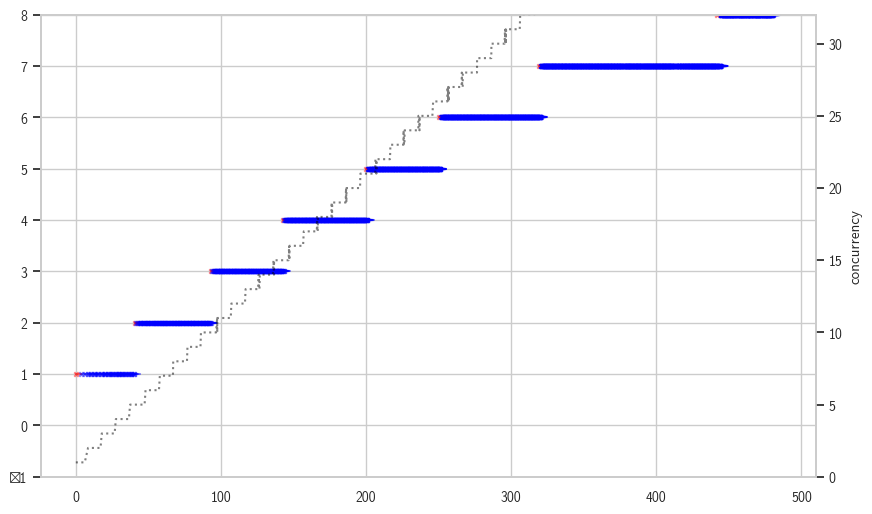

In [320]:
# let's make a simple scatterplot first?
# other way around: by gpu worker
# now plot
fig, ax = plt.subplots(figsize=(10,6))
for i, row in df_graph.iterrows():
    # plot the line
    ax.plot([row["rel_time"], row["outer_end"]], [row["num_workers"], row["num_workers"]], color=("red" if row["cold_start"] else "blue"), alpha=0.5)
    # plot the starting point
    ax.scatter([row["rel_time"]], [row["num_workers"]], color=("red" if row["cold_start"] else "blue"), alpha=0.5, marker="x", s=10)

ax.set(ylim=(-1, 8))

ax2 = ax.twinx()
sns.lineplot(data=df_graph, x="rel_time", y="concurrency", color="black", legend=False, ax=ax2, linestyle=":", alpha=0.5)
ax2.grid(False)
ax2.set(ylim=(0, 32))

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='outer_time', ylabel='Count'>

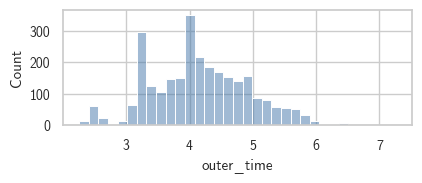

In [321]:
# make a histogram
fig, ax = plt.subplots()
sns.histplot(data=df_graph, x="outer_time", multiple="stack", ax=ax, alpha=0.5)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='outer_time', ylabel='Proportion'>

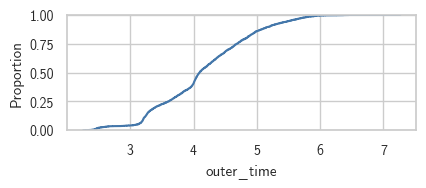

In [322]:
# make a histogram
fig, ax = plt.subplots()
sns.ecdfplot(data=df_graph, x="outer_time", ax=ax)

In [323]:
# plot the throughput
# needs a new throughput dataframe
# count the number of requests per second
# get number of requests answered per second
# rolling window of 1 second
throughput_df = df_graph.copy()
throughput_df["completed"] = 1
throughput_df["rel_time_s"] = pd.to_datetime(arg=throughput_df["rel_time"], unit="s")
throughput_df = throughput_df.rolling(window="1s", on="rel_time_s").agg({"completed": "sum", "rel_time": "max", "concurrency": "max"})
throughput_df["req_per_s"] = throughput_df["completed"] / 1
throughput_df["req_per_s_per_client"] = throughput_df["completed"] / 1 / throughput_df["concurrency"]

In [324]:
throughput_df.head()

,completed,rel_time,concurrency,req_per_s,req_per_s_per_client
0,1.0,0.000000,1.0,1.0,1.0
1,1.0,3.902649,1.0,1.0,1.0
2,1.0,6.174602,1.0,1.0,1.0
3,1.0,8.436930,2.0,1.0,0.5
4,1.0,9.939889,2.0,1.0,0.5


In [325]:
# plot the throughput
# needs a new throughput dataframe
# count the number of requests per second
# get number of requests answered per second
# rolling window of 1 second
completion_time_df = df_graph.copy()
completion_time_df["rel_time_s"] = pd.to_datetime(arg=completion_time_df["rel_time"], unit="s")
completion_time_df = completion_time_df.rolling(window="1s", on="rel_time_s").agg({"outer_time": "mean", "rel_time": "max", "concurrency": "max"})

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

<Axes: xlabel='rel_time', ylabel='req_per_s'>

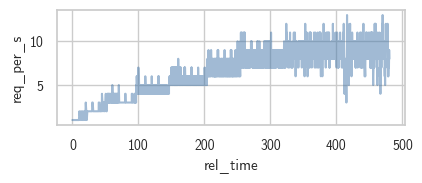

In [326]:
sns.lineplot(data=throughput_df, x="rel_time", y="req_per_s", alpha=0.5)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

[Text(0.5, 0, 'experiment time (s)'),
 Text(0, 0.5, 'throughput\n(req/s/client)')]

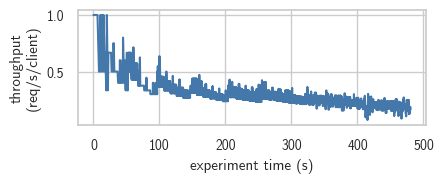

In [327]:
g = sns.lineplot(data=throughput_df, x="rel_time", y="req_per_s_per_client")
g.set(xlabel="experiment time (s)", ylabel="throughput\n(req/s/client)")

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

<Axes: xlabel='rel_time', ylabel='inner_time'>

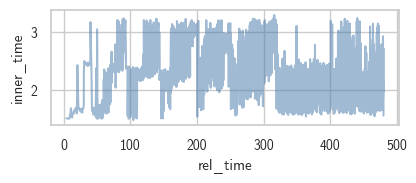

In [328]:
# plot task completion time for warm starts over time
sns.lineplot(data=df_graph[df_graph["cold_start"] == 0], x="rel_time", y="inner_time", alpha=0.5)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

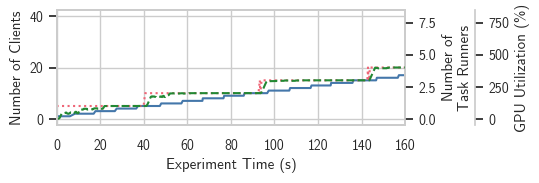

In [329]:
# let's make a nice graph with multiple y axis
fig, ax = plt.subplots(figsize=(4.5,1.5))
ax2 = ax.twinx()
ax3 = ax.twinx()

sns.lineplot(data=combined_rolling_gpu, x="rel_time", y="total_utilization", ax=ax3, color="#228833", linestyle="--")
ax3.set(ylabel="GPU Utilization (%)")
ax3.set(ylim=(-50, 850))
ax3.grid(False)
ax3.spines['right'].set_position(('axes', 1.2))

sns.lineplot(data=throughput_df, x="rel_time", y="concurrency", ax=ax, color ="#4477AA", legend=False)
ax.set(ylabel="Number of Clients")
ax.set(xlabel="Experiment Time (s)")
ax.set(xlim=(0, 160))
ax.set(ylim=(-2.5, 42.5))

sns.lineplot(data=df_graph, x="rel_time", y="num_workers", legend=False, ax=ax2, linestyle=":", color="#EE6677")
ax2.set(ylabel="Number of\nTask Runners")
ax2.set(ylim=(-0.5, 8.5))
ax2.grid(False)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

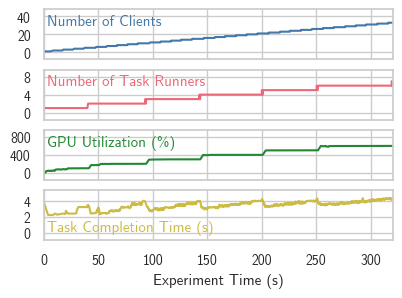

In [330]:
# in percent
buffer_size = 0.2

# make a four cell plot with a shared x axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(4.5, 3))
ax4.set(xlabel="Experiment Time (s)")
ax4.set(xlim=(0, 320))

# plot the throughput
sns.lineplot(data=throughput_df, x="rel_time", y="concurrency", ax=ax1, color ="#4477AA", legend=False)
# ax1.set(ylabel="Number of Clients")
# put text in the top left corner
ax1.text(0.01, 0.9, "Number of Clients", transform=ax1.transAxes, color="#4477AA", verticalalignment='top')
ax1.set(ylabel="")
ax1_min = 0
ax1_max = 40
ax1.set(ylim=(ax1_min-((ax1_max-ax1_min) * buffer_size), ax1_max+((ax1_max-ax1_min) * buffer_size)))
ax1.set_yticks([0, 20, 40])

# plot number of workers
sns.lineplot(data=df_graph, x="rel_time", y="num_workers", legend=False, ax=ax2, color="#EE6677")
# ax2.set(ylabel="Number of\nTask Runners")
ax2.text(0.01, 0.9, "Number of Task Runners", transform=ax2.transAxes, color="#EE6677", verticalalignment='top')
ax2.set(ylabel="")
ax2_min = 0
ax2_max = 8
ax2.set(ylim=(ax2_min-((ax2_max-ax2_min) * buffer_size), ax2_max+((ax2_max-ax2_min) * buffer_size)))

ax2.set_yticks([0, 4, 8])

# plot gpu utilization
sns.lineplot(data=combined_rolling_gpu, x="rel_time", y="total_utilization", ax=ax3, color="#228833")
# ax3.set(ylabel="GPU Utilization (%)")
ax3.text(0.01, 0.9, "GPU Utilization (%)", transform=ax3.transAxes, color="#228833", verticalalignment='top')
ax3.set(ylabel="")
ax3_min = 0
ax3_max = 800
ax3.set(ylim=(ax3_min-((ax3_max-ax3_min) * buffer_size), ax3_max+((ax3_max-ax3_min) * buffer_size)))
ax3.set_yticks([0, 400, 800])


# scatter plot of task completion times
sns.lineplot(data=completion_time_df, x="rel_time", y="outer_time", ax=ax4, color="#CCBB44")
ax4.text(0.01, 0.1, "Task Completion Time (s)", transform=ax4.transAxes, color="#CCBB44", verticalalignment='bottom')
ax4.set(ylabel="")
ax4_min = 0
ax4_max = 4.5
ax4.set(ylim=(ax4_min-((ax4_max-ax4_min) * buffer_size), ax4_max+((ax4_max-ax4_min) * buffer_size)))
ax4.set_yticks([0, 2, 4])

fig.savefig("autoscaling-combined.pdf", bbox_inches="tight")